In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [20]:
data=pd.read_csv('dataset.csv')
data

,Kode Produk,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,...,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep,20-Oct,20-Nov,20-Dec,Cluster
0,P1,56,7,8,14,16,10,21,20,68,...,17,6,9,62,67,62,67,77,11,0
1,P2,164,190,188,164,235,139,662,240,138,...,367,227,55,222,220,85,336,153,103,1
2,P3,65,58,79,109,50,51,73,92,28,...,121,23,30,26,19,23,21,20,7,0
3,P4,243,304,321,241,191,97,276,165,170,...,304,72,102,102,113,112,102,118,120,1
4,P5,10,13,24,14,28,9,19,10,24,...,16,11,7,10,16,18,18,23,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,P154,243,379,292,232,287,107,344,455,436,...,129,85,115,232,79,112,450,498,254,1
154,P155,-5,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,P156,101,65,117,94,197,151,157,159,144,...,152,129,136,177,120,167,153,130,121,1
156,P157,0,0,0,0,0,8,49,93,103,...,19,26,29,49,43,34,51,51,43,0


In [21]:
model=tf.keras.models.load_model('cluster1.h5')

In [22]:
c1 = data.query("Cluster == 1")
print("Jumlah Produk:")
print(c1['Kode Produk'].size)

Jumlah Produk:
45


In [12]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

In [23]:
product=c1.iloc[0]
product

Kode Produk     P2
19-Jan         164
19-Feb         190
19-Mar         188
19-Apr         164
19-May         235
19-Jun         139
19-Jul         662
19-Aug         240
19-Sep         138
19-Oct          90
19-Nov         494
19-Dec         112
20-Jan         179
20-Feb         119
20-Mar         349
20-Apr         367
20-May         227
20-Jun          55
20-Jul         222
20-Aug         220
20-Sep          85
20-Oct         336
20-Nov         153
20-Dec         103
Cluster          1
Name: 1, dtype: object

In [39]:
product=list(product[1:-1])

In [49]:
time=list(range(len(product)))
time

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [50]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=product
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

In [66]:
split_time = 5 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:-split_time]
x_train =  series[:-split_time]
time_valid =  time[-split_time:]
x_valid =  series[-split_time:]

In [67]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [68]:
prediksi=model.predict(time_valid)
prediksi

array([[1.0437948],
       [1.0428953],
       [1.0416032],
       [1.0400217],
       [1.0382313]], dtype=float32)

In [72]:
prediksi=prediksi.flatten()
x_train=x_train.flatten()

In [73]:
hasil_prediksi=np.concatenate(x_train,prediksi)
hasil_prediksi

TypeError: only integer scalar arrays can be converted to a scalar index

ValueError: x and y must have same first dimension, but have shapes (22,) and (17, 5)

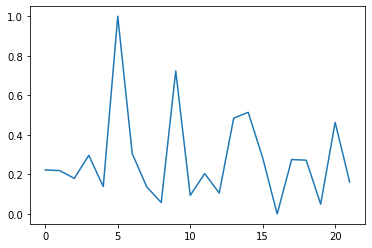

In [59]:
plt.plot(time,series)
plt.plot(time,hasil_prediksi)
plt.plot()